# Step 1: Prepare Data

## Install All Applicable Packages

In [1]:
! pip install pandas
! pip install numpy
! pip install scikit-learn
! pip install matplotlib
! pip install tensorflow
! pip install keras-tuner
! pip install seaborn

  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl (12.9 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl (44.8 MB)
Using cached threadpoolctl-3.

## Import All Applicable Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, brier_score_loss
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import seaborn as sns

## Read Data from Zipped Folder

In [3]:
data_csv = f"./train_cleaned.csv"
df = pd.read_csv(data_csv)

## Transform Data

In Step 2 we will discuss the criteria that allowed us to choose dummies for these columns. In essence, we wanted to **convert categorical attributes into binaries**. These attributes only have 2-3 unique values so it will only add a few extra columns to the data we will analyze.

We will also transform the "label" attribute to a 1 or 0.

In [4]:
# Transform categorical attributes
df_encoded = pd.get_dummies(df, columns=['gender', 'family_history_overweight', 'freq_high_cal_food', 
                                         'alch_in_excess', 'smoker', 'calorie_monitor', 
                                         'alch_consump', 'mode_of_trans'])
# Transform label to binary
df_encoded['label'] = df_encoded['label'].apply(lambda x: 1 if x == 'Overweight' else 0)

## Define Attributes and Label

This steps assigns X with the final attributes that will train the model and y as the label value.

In X we dropped values that are not useful to the training data. 

We removed **ID, label, that label_cat** attribute which categorized the weight label 7 ways. 
**Weight** was removed as it would skew the outcome.
Although **height** would not have an effect on the outcome it was removed so that this study can focus on behavioral lifestyle attributes.

In [5]:
X = df_encoded.drop(columns=['id', 'label', 'label_cat', 'height', 'weight'])
y = df_encoded['label']

## Use K-10 Fold

In [6]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Step 2: Summary Stats

### We will first familiarize ourselves with the raw data

#### Re-read the original data set in so that we can ingest and understand its content

In [7]:
df = pd.read_csv(data_csv)

#### The describe function will give us some top line stats to help understand the numerical attributes

There appears to be 20,758 rows of data. 
The average age of a participant in this study is 23.8 years old. Although the eldest participant is 61, 75% are 26 or younger.
Height is in meters and weight is in kilograms. 
The average respondent claims to eat around 2.5 servings of vegetables per day.
Repondents are also averaging about 2.8 meals per day, with the lowest end at 1 meal per day and the highest at 4.
We see that physical activity is right under about an hour per day per respondent.
Lastly, time using technology ranges from 0 to 2 hours, with the average at a little over half an hour.

This data was collected from Mexico, Peru, and Colombia which explains why some of these answers might slightly differ from the average American's response.

In [8]:
df.describe()

id           age        height        weight  \
count  20758.00000  20758.000000  20758.000000  20758.000000   
mean   10378.50000     23.841850      1.700085     87.887761   
std     5992.46278      5.688115      0.087515     26.379438   
min        0.00000     14.000000      1.450000     39.000000   
25%     5189.25000     20.000000      1.630000     66.000000   
50%    10378.50000     22.820000      1.700000     84.060000   
75%    15567.75000     26.000000      1.760000    111.600000   
max    20757.00000     61.000000      1.980000    165.060000   

       freq_veg_consump  meals_per_day  water_consump  freq_physical_activity  \
count      20758.000000   20758.000000   20758.000000            20758.000000   
mean           2.445919       2.761317       2.029422                0.981811   
std            0.533281       0.705399       0.608512                0.838335   
min            1.000000       1.000000       1.000000                0.000000   
25%            2.000000       3.000000       1.790000                0.010000   
50%            2.390000       3.000000       2.000000                1.000000   
75%            3.000000       3.000000       2.550000                1.590000   
max            3.000000       4.000000       3.000000                3.000000   

       time_using_tech  
count     20758.000000  
mean          0.616697  
std           0.602135  
min           0.000000  
25%           0.000000  
50%           0.570000  
75%           1.000000  
max           2.000000

#### The info function will allow us to understand the data types available

Aside from the numerical attributes above, we also have categorical ones.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         20758 non-null  int64  
 1   gender                     20758 non-null  object 
 2   age                        20758 non-null  float64
 3   height                     20758 non-null  float64
 4   weight                     20758 non-null  float64
 5   family_history_overweight  20758 non-null  object 
 6   freq_high_cal_food         20758 non-null  object 
 7   freq_veg_consump           20758 non-null  float64
 8   meals_per_day              20758 non-null  float64
 9   alch_in_excess             20758 non-null  object 
 10  smoker                     20758 non-null  object 
 11  water_consump              20758 non-null  float64
 12  calorie_monitor            20758 non-null  object 
 13  freq_physical_activity     20758 non-null  flo

#### This loop will show us all the unique values per attribute

Here, we will print all the unique column options in the categorical attributes.

This data was initially seperated into 7 different label categories with one class for "Insufficient Weight", another for "Normal Weight", 2 classes for "Overweight", and 2 classes for "Obese". 

For the purposes of this study, **we classed Insufficient and Normal into a new label called Normal. 
Then, the Overweight and Obese categories were grouped into one value called Overweight.**

In [10]:
for i, col in enumerate(df.columns):
    if df[col].dtype == 'object': 
        print(f"Unique values in column '{col}':")
        print(df[col].unique())
        print()


Unique values in column 'gender':
['Male' 'Female']

Unique values in column 'family_history_overweight':
['yes' 'no']

Unique values in column 'freq_high_cal_food':
['yes' 'no']

Unique values in column 'alch_in_excess':
['Sometimes' 'Frequently' 'no' 'Always']

Unique values in column 'smoker':
['no' 'yes']

Unique values in column 'calorie_monitor':
['no' 'yes']

Unique values in column 'alch_consump':
['Sometimes' 'no' 'Frequently']

Unique values in column 'mode_of_trans':
['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']

Unique values in column 'label_cat':
['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']

Unique values in column 'label':
['Overweight' 'Normal']



#### Finally, the head function will give us a small glimpse into the raw data

In [11]:
print(df.head())

   id  gender    age  height  weight family_history_overweight  \
0   0    Male  24.44    1.70   81.67                       yes   
1   1  Female  18.00    1.56   57.00                       yes   
2   2  Female  18.00    1.71   50.17                       yes   
3   3  Female  20.95    1.71  131.27                       yes   
4   4    Male  31.64    1.91   93.80                       yes   

  freq_high_cal_food  freq_veg_consump  meals_per_day alch_in_excess smoker  \
0                yes              2.00           2.98      Sometimes     no   
1                yes              2.00           3.00     Frequently     no   
2                yes              1.88           1.41      Sometimes     no   
3                yes              3.00           3.00      Sometimes     no   
4                yes              2.68           1.97      Sometimes     no   

   water_consump calorie_monitor  freq_physical_activity  time_using_tech  \
0           2.76              no                   

### Visualize the distribution of Normal vs Overweight categorization in the data using the countplot function

The data is composed of 27% labeled as "Normal" and 72% as "Overweight."

Although it may seem that normalization is necessary given this distribution, it had little to no effect on this data. 

In Random Forest, normalization isn't usually needed because it’s a tree-based model that focuses on data structure and splits rather than feature scales. 

For KNN and GRU, normalization usually helps because it’s a distance-based model, but in this case, the feature ranges are already very close that scaling did not impact results. 

In summary - normalization helps smooth the data when the distance between points varies widely, but in this case the data points already hovered in the a smaller range, so normalization is less critical here.

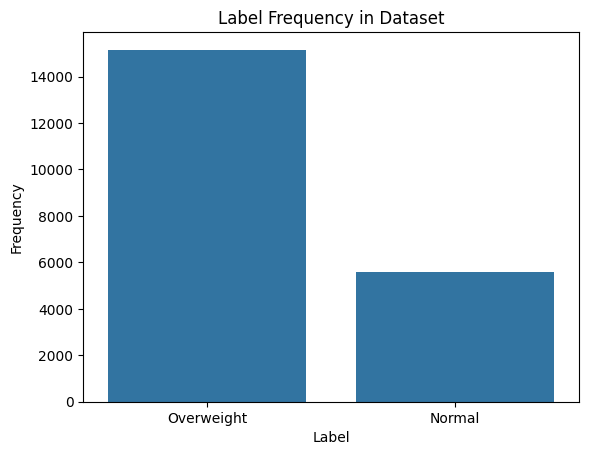

label
Overweight    15153
Normal         5605
Name: count, dtype: int64

label
Overweight    73.0%
Normal        27.0%
Name: proportion, dtype: object


In [12]:
sns.countplot(x='label', data=df)
plt.title("Label Frequency in Dataset")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

dist = df['label'].value_counts()
percentages = (df['label'].value_counts(normalize=True) * 100).round(2).astype(str) + '%'
print (f"{dist}\n")
print(percentages)

#### Identify Correlation

To identify and reduce redundancy in our data, we created a correlation matrix to find relationships between features.

In the correlation matrix below, we included all dummy variables for categorical data, resulting in a large and complex matrix that’s difficult to interpret. Additionally, binary attributes (such as Yes/No variables) show perfect correlations with each other, which can clutter the matrix. To create a cleaner version, we will drop the first dummy variable for each category in the following matrix.

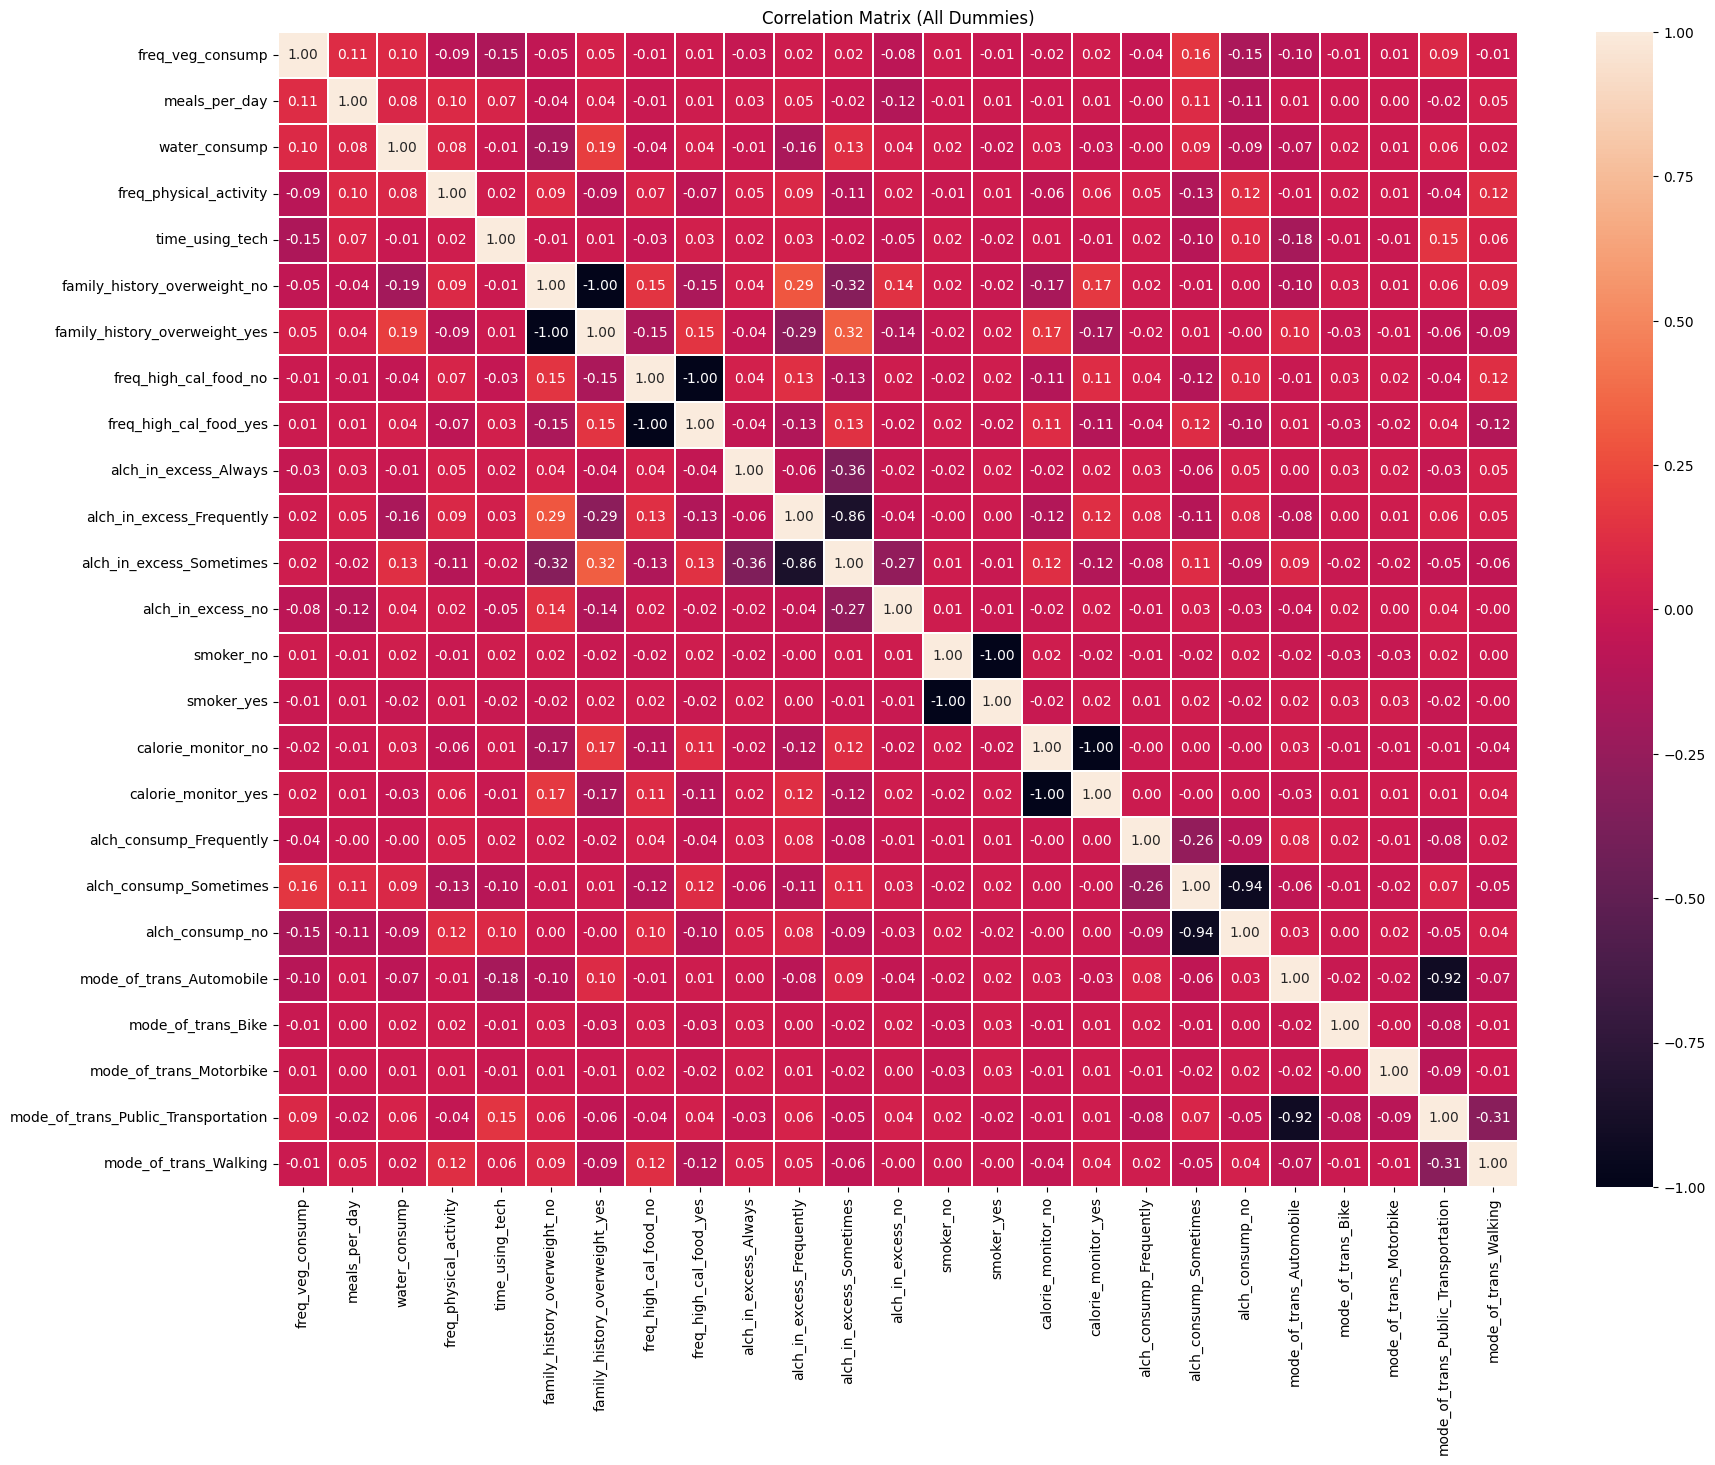

In [13]:
selected_columns = [
    'family_history_overweight', 'freq_high_cal_food', 'freq_veg_consump', 
    'meals_per_day', 'alch_in_excess', 'smoker', 'water_consump', 
    'calorie_monitor', 'freq_physical_activity', 'time_using_tech', 
    'alch_consump', 'mode_of_trans'
]

df_selected = df[selected_columns]

df_dum = pd.get_dummies(df_selected)

correlation_matrix = df_dum.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.1)
plt.title("Correlation Matrix (All Dummies)")
plt.show()


In this refined correlation matrix, there are still strong correlations among some dummy variables with three or more unique values. However, we can now clearly observe that the other features have low correlations. This confirms that the current set of attributes is **sufficiently distinct**.

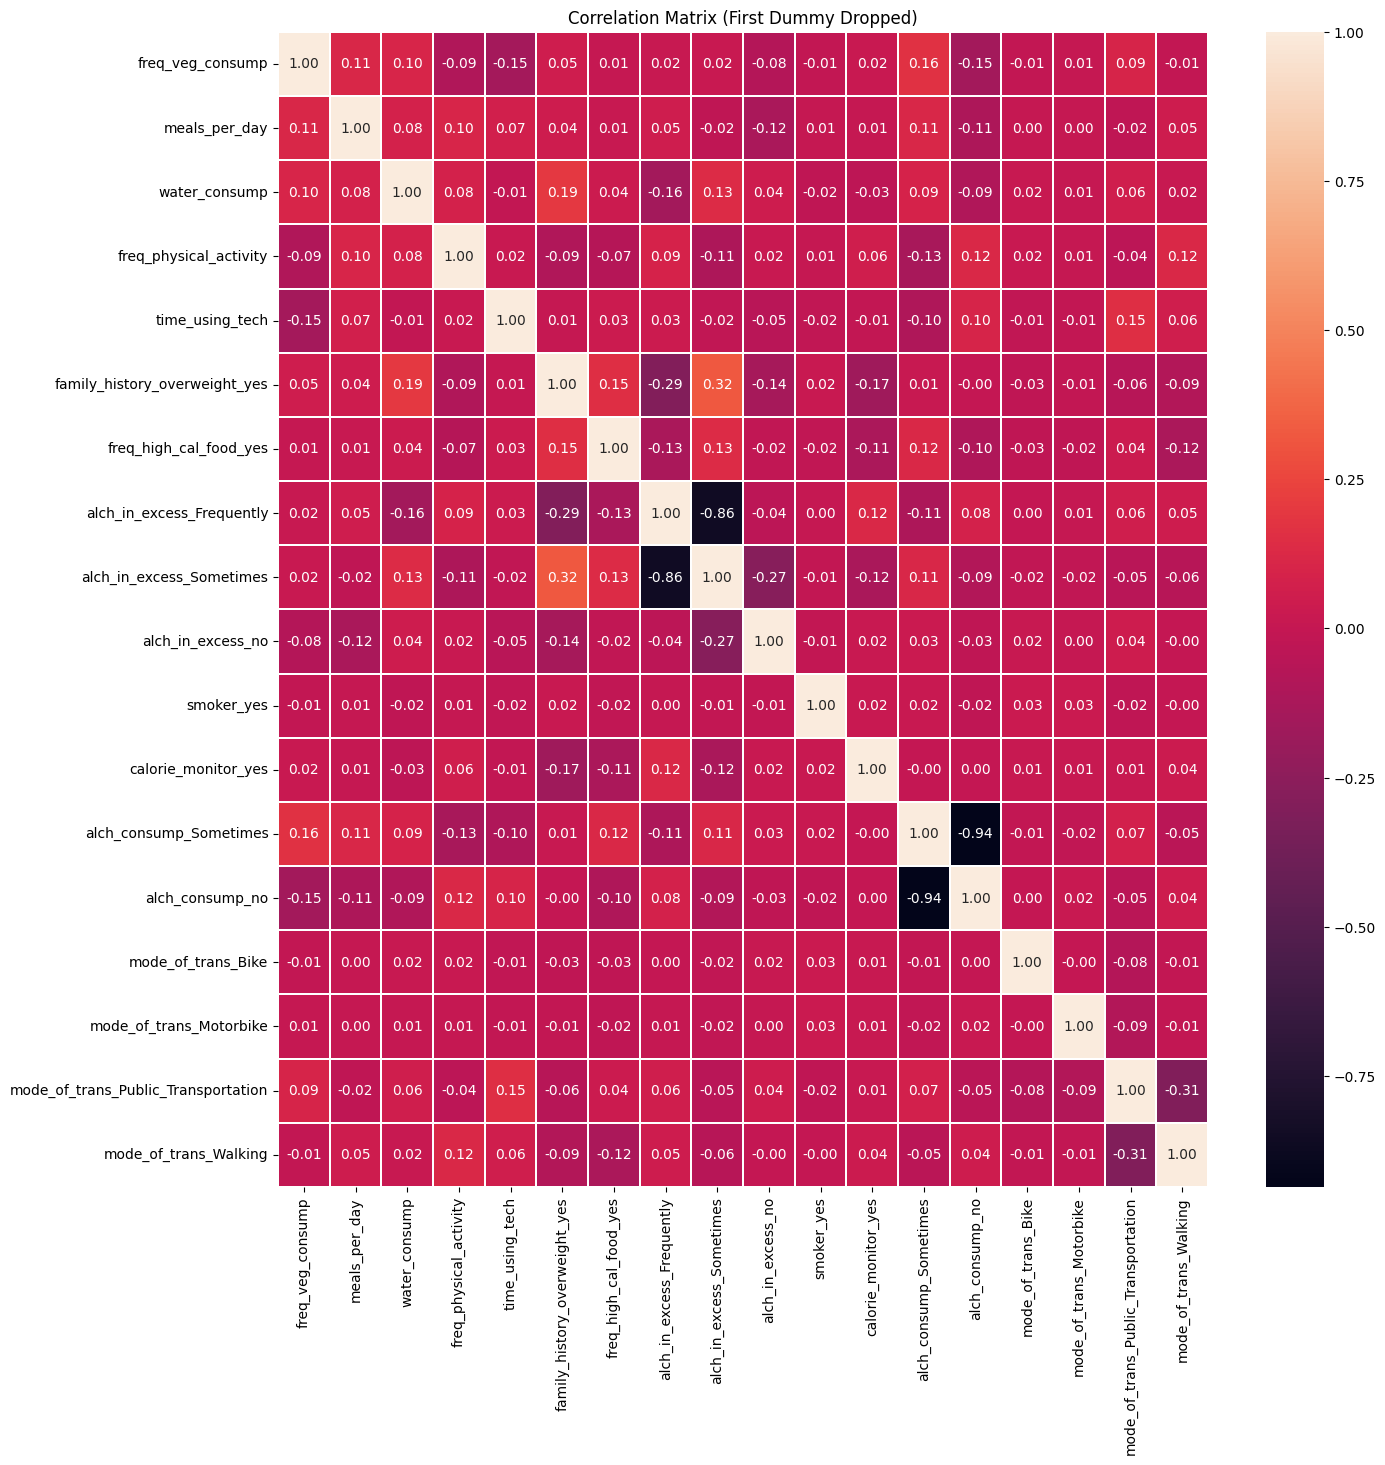

In [14]:
df_dum2 = pd.get_dummies(df_selected, drop_first=True)

correlation_matrix = df_dum2.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.1)
plt.title("Correlation Matrix (First Dummy Dropped)")
plt.show()


### Histograms of Attributes

Again, since some of our attributes are catgegorical and some are numerical, the following code will allow us to understand how the data is distributed per attribute.

Histograms are in blue and bar charts are in red.

The most notable findings from the histograms is that this data appears to be collected from participants mainly in the **20-30 age range**. 

There is an **even split of male to female participants**. 

**Height** is the only attribute that follows a **bell curve** structure. 

The **family history overweight** attribute follows a similar patter to the label we saw a few steps earlier. 

Most participants are **not smokers, do not monitor calories, and report eating 3 meals a day**.

Like mentioned prior, since this data was collected from Colombia, Peru, and Mexico we see that the main mode of transport is **Public Transport**.

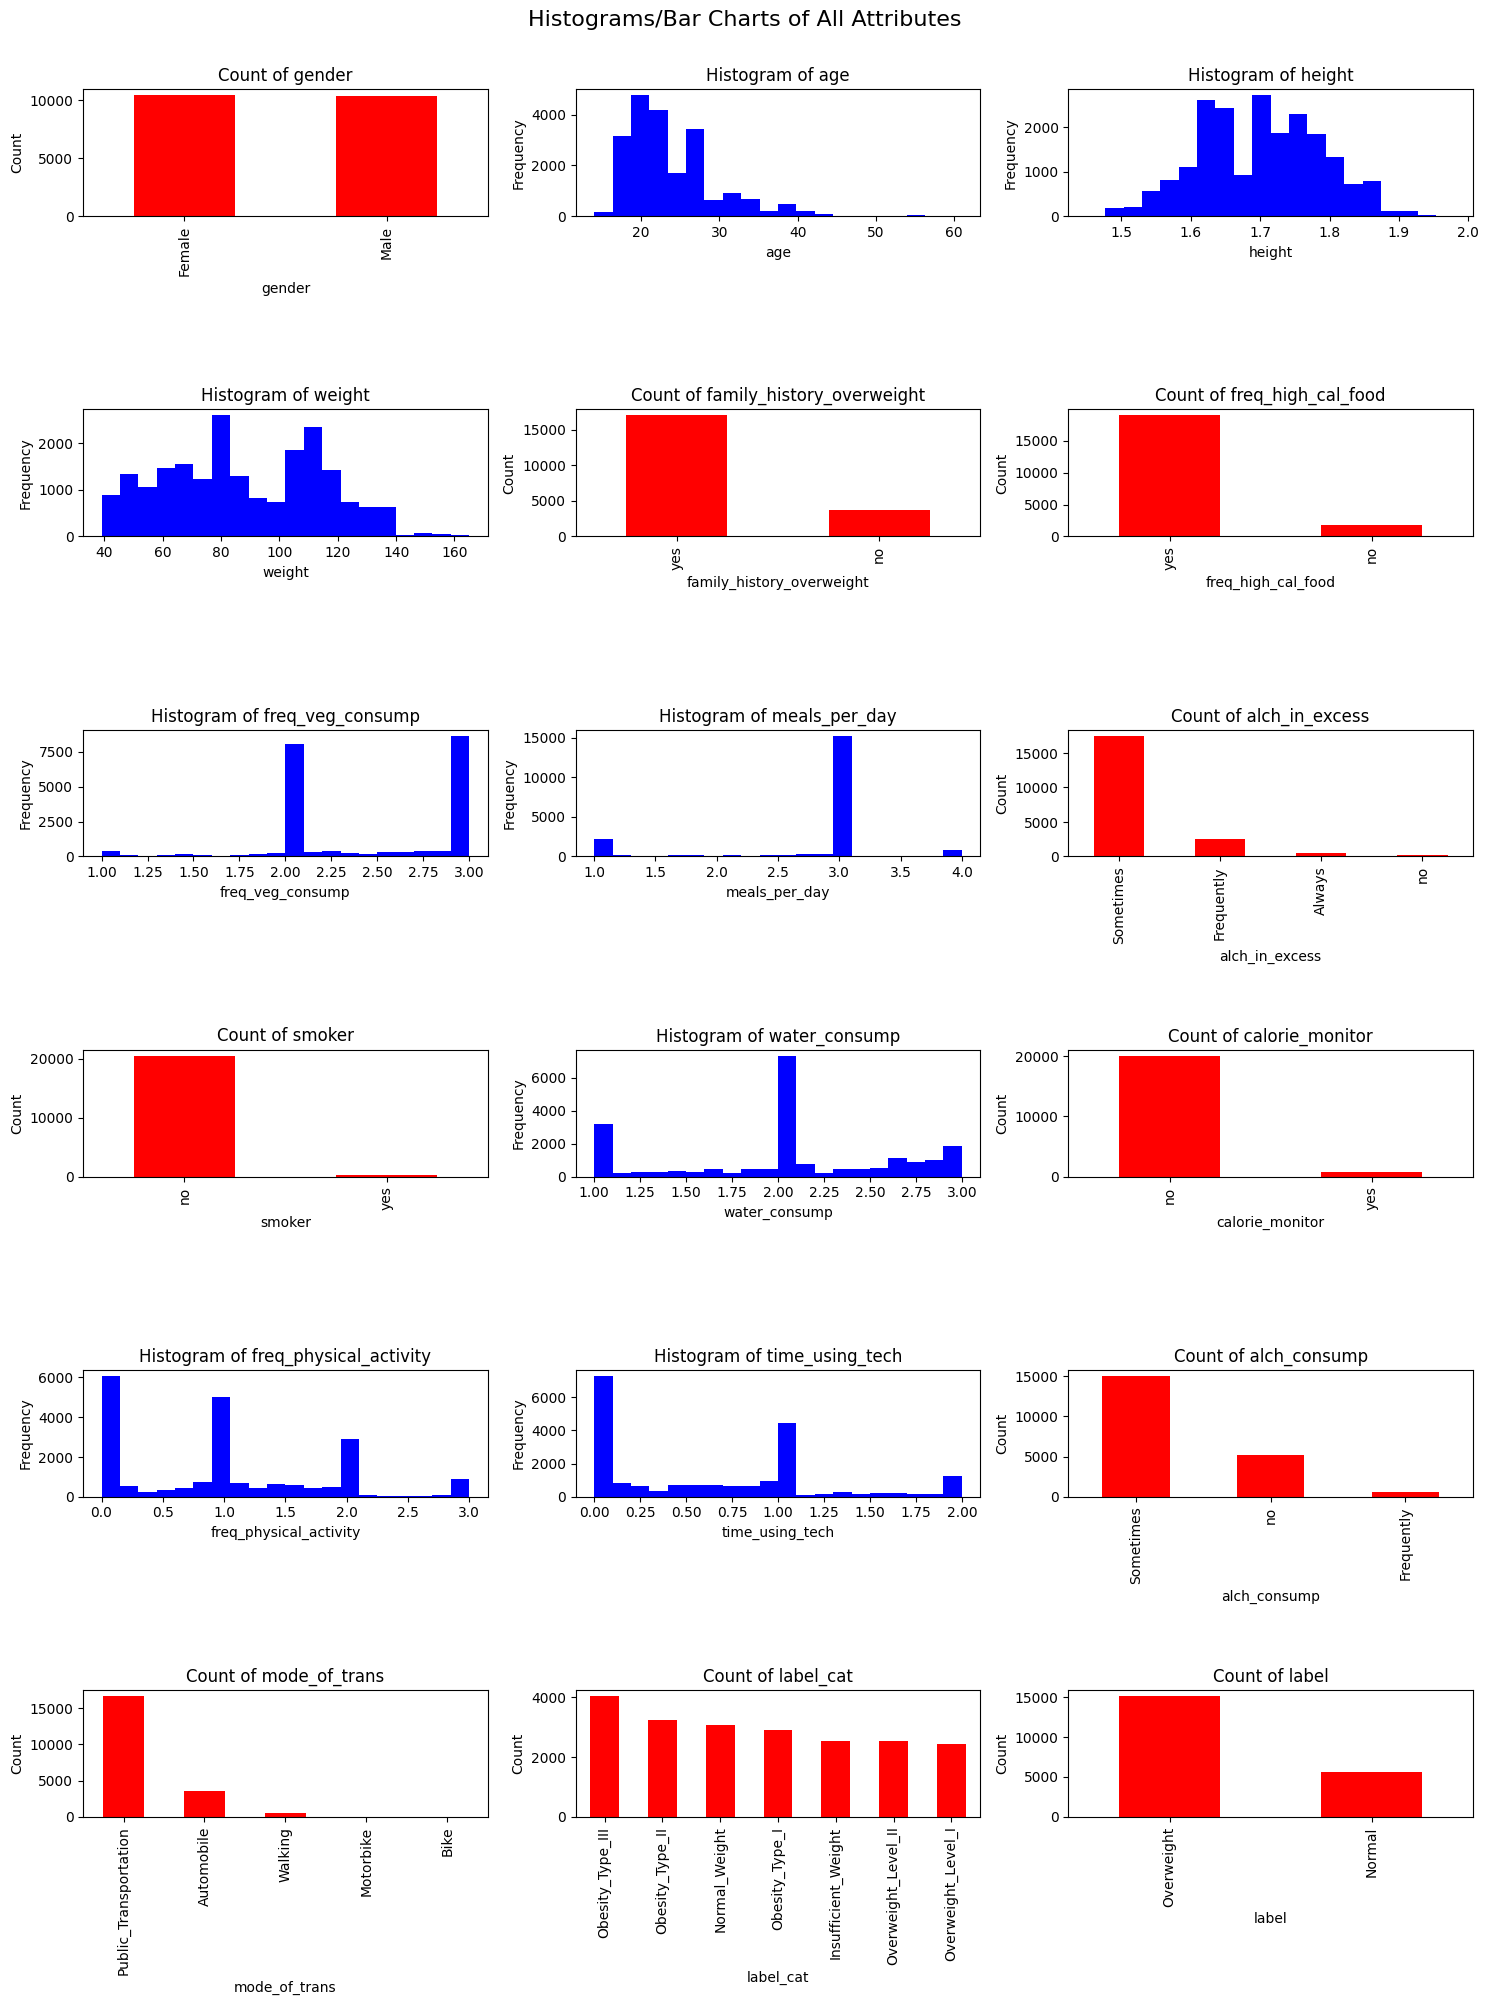

In [15]:
df_bp = df.drop(columns=['id'])

num_columns = len(df_bp.columns)
fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(15, 3 * (num_columns // 3 + 1)))
axes = axes.flatten()

# Loop through each column and create a histogram or bar plot
for i, col in enumerate(df_bp.columns):
    if df_bp[col].dtype in ['int64', 'float64']:  # Numeric cols
        df_bp[col].plot(kind='hist', bins=20, ax=axes[i], color='blue')
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    else:  # Categorical cols
        df_bp[col].value_counts().plot(kind='bar', ax=axes[i], color='red')
        axes[i].set_title(f'Count of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Histograms/Bar Charts of All Attributes", y=1.02, fontsize=16)
plt.show()


#### Pairplots

Pair plots visualize relationships between pairs of features in a dataset by displaying scatter plots for each feature pair. They help identify clusters and class separations. Here we will visualize the pairplots for our numeric attributes.

As expected, weight perfectly clusters with "Normal" to one side and "Overweight" to the other side.

Height, vegetable consumption, water consumption, and time using technology do not seem to follow any clear patterns.

On the other hand, meals per day sees clusters across all variables for "Normal" in the 3-4 range.

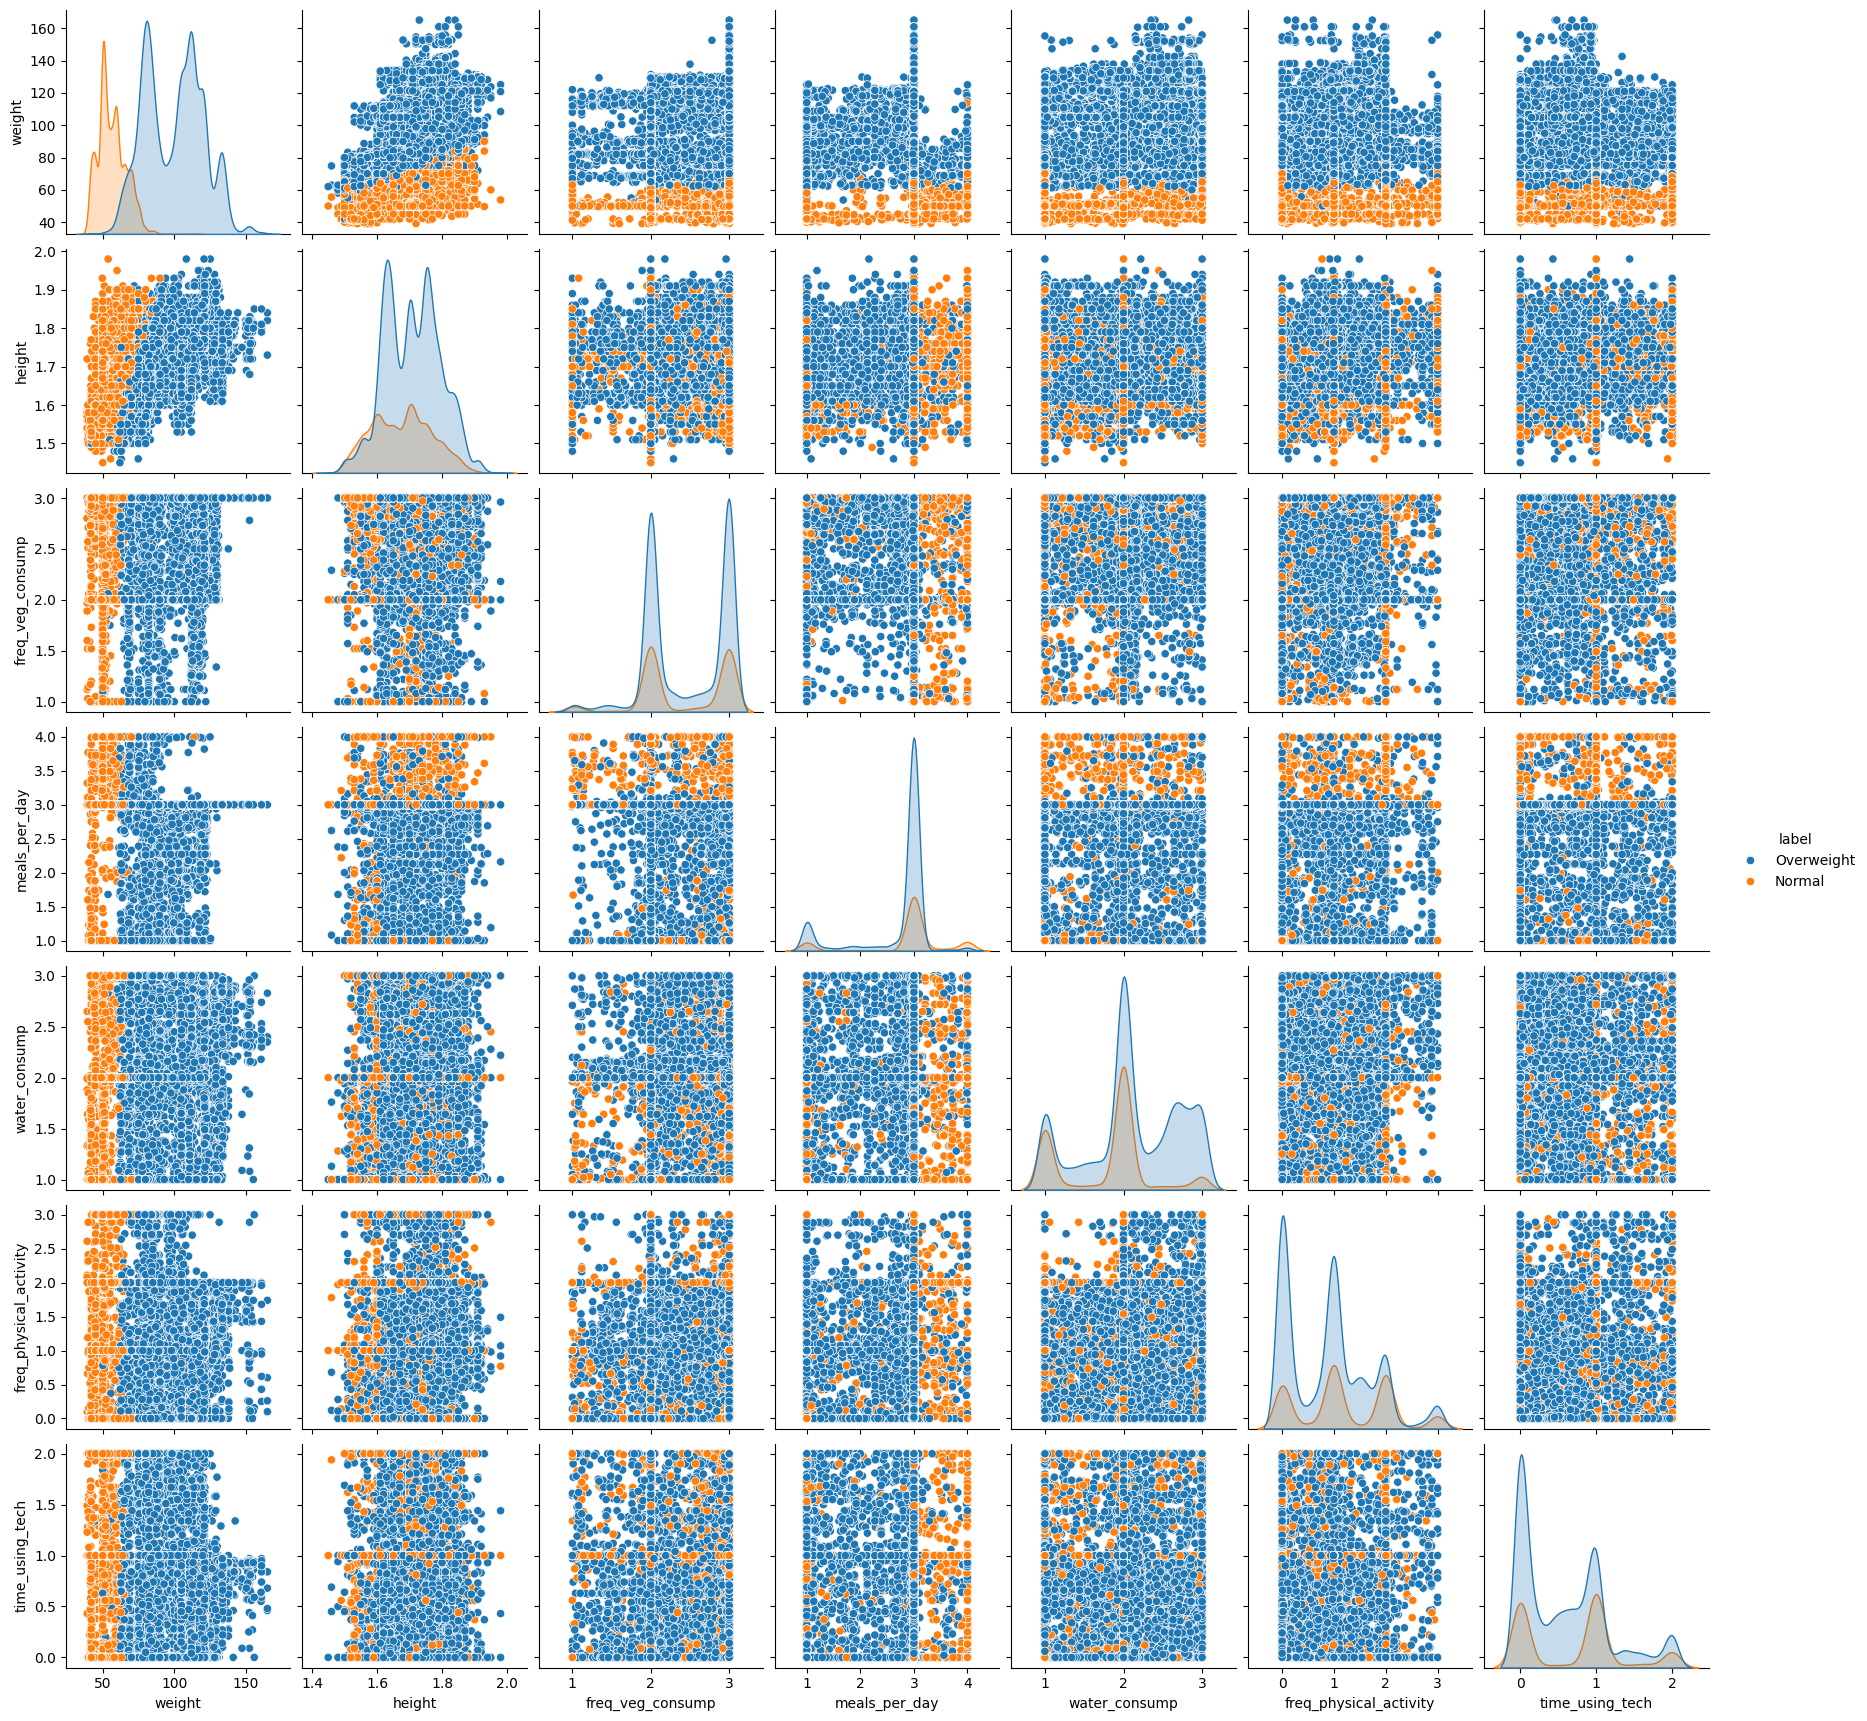

In [16]:
selected_columns2 = [
     'weight', 'height', 'freq_veg_consump', 'meals_per_day','water_consump', 'freq_physical_activity', 'time_using_tech',  'label'
]

df_selected2 = df[selected_columns2]

sns.pairplot(df_selected2, hue='label')
plt.show()


# Step 3: Parameter Tuning

#### PLEASE NOTE THAT SOME OF THESE BLOCKS TAKE ABOUT ***AN HOUR*** TO COMPUTE.
#### STEP 4 WILL RUN WITHOUT SMOOTHLY ***WITHOUT*** STEP 3 SINCE IT IS HARD CODED.
#### ***FEEL FREE TO READ THROUGH STEP 3 WITHOUT RUNNING.***

### Random Forest Optimization

For random forest, we will optimize for the best number of trees in the forest as well as the minimum number of splits in a node. This is different to the number of splits in the k-fold discussed earlier. The purpose of it is to control the growth of individual trees. 

We use the GridSearchCV function to test different combinations of estimators and minimum sample splits. After evaluation each combination by calculation the ROC-AUC metric, this code prints the best combination.

After running the optimization below, we find that a higher number of trees/estimators and a higher sample split threshold yields the hgighest AUC score, specifically **200 trees** and a **minimum split threshold of 10**.

In [17]:
param_grid_rf = {
    "n_estimators": [50, 100, 150, 200],
    "min_samples_split": [2, 4, 6, 8, 10]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='roc_auc'
)

grid_search_rf.fit(X, y)

best_rf_params = grid_search_rf.best_params_
best_rf_score = grid_search_rf.best_score_

print("Optimal Parameters:", best_rf_params)

Optimal Parameters: {'min_samples_split': 10, 'n_estimators': 200}


### KNN Optimization

Similar to the random forest fine tuning, this code looks for k-values in the range of 1 to 39. The metric it uses to choose the optimal k-value is the 10-fold average AUC. In this case we found that **k-value to be 28**.

In [18]:
k_values = range(1, 40)
average_auc_scores = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    auc_scores = []
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        knn_model.fit(X_train, y_train)
        
        y_pred_prob = knn_model.predict_proba(X_test)[:, 1]
        
        auc_score = roc_auc_score(y_test, y_pred_prob)
        auc_scores.append(auc_score)
    
    average_auc_scores.append(np.mean(auc_scores))

optimal_k = k_values[np.argmax(average_auc_scores)]
best_auc_score = max(average_auc_scores)

print(f"Optimal number of neighbors: {optimal_k}")

Optimal number of neighbors: 28


### GRU Optimization

First, what is GRU? GRU stands for Gated Recurrent Unit. It is a type of neural network designed for sequential data. It works by remembering important information from earlier steps while "forgetting" less relevant details. Fine-tuning GRU helps the model decide the right balance between what to remember and what to forget. While our data isn’t naturally sequential, we can reshape it to treat features as sequential steps. Although GRU isn’t traditionally used for this type of data, reshaping it and applying GRU has proven to be a reasonable approach.

For our GRU model, we’ll focus on optimizing three key parameters: units, dropout, and learning rate.

Units represent the number of neurons in the GRU layer. More units allow the model to capture complex patterns, while fewer units make the model simpler and faster but may lead to underfitting.

Dropout refers to the rate at which the model “forgets” certain connections during training. A higher dropout rate can help prevent overfitting but may also risk underfitting if set too high.

Learning rate controls the size of each adjustment the model makes during training. A smaller learning rate leads to slower, more stable learning, while a larger one speeds up training but risks overshooting the optimal solution.

By tuning these parameters, we aim to build a GRU model that works well even with our reshaped non-sequential data.

Running the code below will give us **256 units**, **dropout rate of 0.4**, and **learning rate: 0.0022692999466626704.**

In [ ]:
X_reshaped = np.array(X).astype('float32').reshape((X.shape[0], X.shape[1], 1))

def build_gru_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_reshaped.shape[1], 1)))
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='gru_tuning',
    project_name='gru_tuning_project'
)

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal number units in GRU layer {best_hps.get('units')}.
Optimal dropout rate: {best_hps.get('dropout')}.
Optimal learning rate: {best_hps.get('learning_rate')}.
""")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
96                |96                |units
0.5               |0.5               |dropout
0.0012706         |0.0012706         |learning_rate


Epoch 1/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7333 - loss: 0.5393 - val_accuracy: 0.7592 - val_loss: 0.4792
Epoch 2/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7635 - loss: 0.4659 - val_accuracy: 0.7587 - val_loss: 0.4755
Epoch 3/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7745 - loss: 0.4637 - val_accuracy: 0.7592 - val_loss: 0.4733
Epoch 4/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7716 - loss: 0.4663 - val_accuracy: 0.7738 - val_loss: 0.5095
Epoch 5/10
 26/519 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8219 - loss: 0.3980

# Step 4: Algorithms

In [ ]:
from random_forest import rf

rf_metrics_df_rf = rf(X, y, kf)

In [ ]:
from knn import knn

rf_metrics_df_kn = knn(X, y, kf)

In [ ]:
from gru import gru

X_np = X.to_numpy().astype('float32')
rf_metrics_df_gr = gru(X_np, y, kf)